## Introduction au problème I

L'entreprise *Car-Nivor* souhaite se lancer dans la production de voitures et a déjà imaginé plusieurs modèles. Elle commence par analyser le marché avec les modèles **Tiger (A)** et **Piranha (B)**. 

Voici les informations qui ressortent de cette analyse :

- Le modèle **A** lui apporte un bénéfice de 3 000 € par unité vendue, tandis que le modèle **B** lui apporte un bénéfice de 2 000 € par unité vendue.
- La production d'une voiture de modèle **A** prend 2 heures tandis que celle d'une voiture de modèle **B** prend seulement 1 heure^[Ces valeurs sont clairement fantaisistes et ne reflètent pas du tout le temps moyen d'assemblage réel d'une voiture, qui dépend de nombreux facteurs.].
- Pour des raisons d'absorption de marché, *Car-Nivor* ne peut pas vendre plus de 100 modèles **A**, 100 modèles **B** et 150 voitures **(A+B)** au total par mois.
- Enfin, l'usine de production n'est disponible que 200 heures par mois.

## Modélisation du problème I

> Avant de se lancer tête baissée dans l'utilisation d'un modèle de **Boosting**, réfléchissons un peu et posons-nous quelques questions.

1. **Quelles quantités peut-on faire varier ?** $\Rightarrow$ Les quantités de modèles **A** et **B**.
2. **Que cherche-t-on à optimiser ?** $\Rightarrow$ Le profit de *Car-Nivor*.
3. **Quelles sont les contraintes du problème ?** $\Rightarrow$ Les contraintes de production et les contraintes de marché

:::callout-note

On voit en fait qu'on peut formuler cet énoncé sous la forme d'un problème d'optimisation linéaire sous contraintes !

:::


Plus précisément, on considère les notations suivantes :

- $x_1$ est la quantité vendue de modèle **A**,
- $x_2$ est la quantité vendue de modèle **B**,
- $M_1$ est le bénéfice en k€ par unité vendue de modèle **A**,
- $M_2$ est le bénéfice en k€ par unité vendue de modèle **B**,
- $z$ est le profit de *Car-nivor*, qu'on souhaite maximiser -- on parle de **fonction objectif**,
- $S$ correspond à l'ensemble des contraintes du problème.

***

$$
\max_{slc \hspace{1mm} (S)} z = M_1x_1 + M_2x_2
$$

$$
\max_{slc \hspace{1mm} (S)} z = 3x_1 + 2x_2
$$

$$
(S) : \left \{ 
\begin{array}\\
    x_1\geq 0 \hspace{0.1em} ; \hspace{0.1em} x_2 \geq 0\\
    x_1 \leq 100 \\
    x_2 \leq 100 \\
    2x_1 + x_2 \leq 200 \\
    x_1 + x_2 \leq 150
         \end{array} 
                        \right.
$$

:::callout-tip

## Interprétation des contraintes

1. La première contrainte indique qu'on ne peut pas produire de quantité négative de voiture,
2. La seconde contrainte indique qu'on ne peut pas vendre plus de 100 modèles de type **A**,
3. La troisième contrainte indique qu'on ne peut pas vendre plus de 100 modèles de type **B**,
4. La quatrième contrainte porte sur le temps de disponibilité de l'usine *(200h)*,
5. La dernière contrainte indique qu'il est possible de produire au maximum 150 voitures de Type **A** ou **B**, et pas plus.

:::

## Résolution du problème I

### Import des librairies et configuration

In [1]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
from rich import print
from rich.panel import Panel
import sympy as sym
import pandas as pd
from math import pi

In [2]:
plt.rcParams["figure.dpi"] = 600

### Représentation graphique du problème

> On peut facilement représenter dans un graph en $2D$ l'ensemble des contraintes et proposer une solution graphique au problème puisqu'on dispose uniquement de 2 variables.

In [3]:
x = np.linspace(0, 150, 500)
y2 = 200 - 2 * x
y3 = 150 - x
z = (350 - 3 * x) / 2

In [4]:
# | fig-align: center
# | fig-width: 50%
# | fig-height: 50%
# | code-fold: true
# | code-summary: "Code du graphique `matplotlib`"
plt.hlines(
    y=100, xmin=0, xmax=150, linewidth=2, color="r", label="$x_2 ≤ 100$", zorder=1
)
plt.vlines(
    x=100, ymin=0, ymax=150, linewidth=2, color="m", label="$x_1 ≤ 100$", zorder=1
)
plt.plot(x, y2, label="$2x_1 + x_2 \leq 200 $", zorder=1)
plt.plot(x, y3, label="$x_1 + x_2 \leq 150$", zorder=1)
plt.plot(x, z, label="$z = 350k$", zorder=1)

plt.scatter(50, 100, color="black", zorder=2)
plt.fill_between([0, 49.9], [100, 100], [0, 0], hatch="//", color="blue", alpha=0.2)
plt.fill_between(
    x,
    np.min([y2, y3], axis=0),
    where=y2 < 100,
    color="blue",
    alpha=0.2,
    hatch="//",
    interpolate=True,
    label="$admissible$",
)

plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.ylim([0, 125])
plt.xlim([0, 125])

plt.title("Ensemble des solutions admissibles")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Mise sous forme normale du problème

On a 4 équations dans le système des contraintes donc le rang est égal à 4.

Les variables positives sont appelées les variables de base :

$$
\beta = \begin{pmatrix}
X_1\\
X_2\\
X_3\\
X_4\\
\end{pmatrix}
$$

L'idée est ensuite d'exprimer les variables de base en fonction des variables hors base ($x_1$ et $x_2$) $\Rightarrow$ On réécrit donc le système comme suit :

$$
\left \{ 
\begin{array}\\
    X_1 = 100 - x_1\\
    X_2 = 100 - x_2\\
    X_3 = 200 - 2x_1 - x_2\\
    X_4 = 150 - x_1 - x_2\\
\end{array}
\right.
$$

### Résolution avec `scipy`

> Le *submodule* `scipy.optimize` fournit un ensemble de fonctions pour minimiser (ou maximiser) des fonctions objectif, possiblement sujettes à certaines contraintes.

Il faut d'abord écrire les matrices de travail avec `numpy`.

In [5]:
cost_1 = np.array([3, 2])
lhs_1 = np.array([[1, 0], [0, 1], [2, 1], [1, 1]])
rhs_1 = np.array([100, 100, 200, 150])

- `cost_1` correspond à la matrice de coût, *i.e.* les coefficients $M_1$ et $M_2$,
- `lhs_1`^[**LHS** = *Left Hand Side* / Premier membre d'une équation.] correspond au premier membre de la matrice des contraintes,
- `rhs_1`^[**RHS** = *Right Hand Side* / Second membre d'une équation.] correspond au second membre de la matrice des contraintes.

Prévisualisons-les avec `sympy`.

In [6]:
display(sym.Matrix(cost_1))
display(sym.Matrix(lhs_1))
display(sym.Matrix(rhs_1))

Matrix([
[3],
[2]])

Matrix([
[1, 0],
[0, 1],
[2, 1],
[1, 1]])

Matrix([
[100],
[100],
[200],
[150]])

Pour résoudre le problème, on peut utiliser la fonction `linprog` du *submodule* `scipy.optimize`, dont l'algorithme effectue par défaut une minimisation.

Comme nous souhaitons plutôt maximiser la fonction objectif, il faut inverser le signe de la fonction de coût.

In [7]:
result_1 = so.linprog(-cost_1, A_ub=lhs_1, b_ub=rhs_1, method="highs")

Profitons-en aussi pour créer les fonctions : 

- `total_profit` qui retourne le profit total optimal,
- `details` qui affiche le profit ainsi que les quantités de voitures vendues. 

In [8]:
# | code-fold: true
# | code-summary: "Code des fonctions"
def total_profit(result: so._optimize.OptimizeResult, cost: np.ndarray) -> np.float64:

    """Retourne le profit total en € lié à la vente de voitures."""

    return np.sum(result["x"] * cost * 1000)


def details(result: so._optimize.OptimizeResult, cost: np.ndarray, types: list) -> str:
    """
    Affiche un message contenant le profit optimal réalisé
    ainsi que le nombre et le type de voiture vendues.
    """
    profit = int(total_profit(result, cost))
    message = f"""
Le profit optimal réalisé par [i]Car-Nivor[/i] est de [u]{profit}[/u] € par mois.
    
=> Pour :
    
"""
    for voiture, type_voiture in zip(result["x"], types):
        message += f"- {voiture.astype(int)} voitures vendues de [red][b]Type {type_voiture}[/b][/red] \n"
    return Panel(message)

Il suffit maintenant d'appeler la fonction `details` pour obtenir les résultats.

In [9]:
details(result_1, cost_1, ["A", "B"])

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Le profit optimal réalisé par Car-Nivor est de 350000 € par mois.                                               │
│                                                                                                                 │
│ => Pour :                                                                                                       │
│                                                                                                                 │
│ - 50 voitures vendues de Type A                                                                                 │
│ - 100 voitures vendues de Type B                                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Effondrement de la demande en modèle **B**

> A cause de constructeurs chinois, *Car-Nivor* ne peut plus écouler qu'un maximum de 50 voitures par mois.

#### Graphique de la situation

In [10]:
# | fig-align: center
# | fig-width: 50%
# | fig-height: 50%
# | code-fold: true
# | code-summary: "Code du graphique `matplotlib`"
plt.hlines(y=50, xmin=0, xmax=150, linewidth=2, color="r", label="$x_2 ≤ 50$", zorder=1)
plt.vlines(
    x=100, ymin=0, ymax=150, linewidth=2, color="m", label="$x_1 ≤ 100$", zorder=1
)

z = (325 - 3 * x) / 2

plt.plot(x, y2, label="$2x_1 + x_2 \leq 200 $", zorder=1)
plt.plot(x, y3, label="$x_1 + x_2 \leq 150$", zorder=1)
plt.plot(x, z, label="$z = 325k$", zorder=1)

plt.scatter(75, 50, color="black", zorder=2)

plt.fill_between(
    [0, 75],
    [49.9, 49.9],
    [0, 0],
    hatch="//",
    color="blue",
    alpha=0.2,
    interpolate=True,
    label="$admissible$",
)

plt.fill_between(
    x, y2, hatch="//", color="blue", where=y2 < 50, alpha=0.2, interpolate=True
)

plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.ylim([0, 125])
plt.xlim([0, 125])
plt.title("Ensemble des solutions admissibles")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Pour une résolution numérique
, il suffit simplement de changer le second membre de la matrice des contraintes.

In [11]:
rhs_2 = np.array([100, 50, 200, 150])

In [12]:
result_2 = so.linprog(-cost_1, A_ub=lhs_1, b_ub=rhs_2, method="highs")

In [13]:
details(result_2, cost_1, ["A", "B"])

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Le profit optimal réalisé par Car-Nivor est de 325000 € par mois.                                               │
│                                                                                                                 │
│ => Pour :                                                                                                       │
│                                                                                                                 │
│ - 75 voitures vendues de Type A                                                                                 │
│ - 50 voitures vendues de Type B                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

***

On voit qu'un effondrement de la demande en voiture de Type **B** entraîne une surproduction de voitures de Type **A**, mais que cette surproduction ne permet pas d'obtenir le profit optimal avant l'effondrement de la demande de Type **B**.

### Analyse détaillée du problème

On veut étudier graphiquement l'évolution du profit en fonction du nombre maximal de voitures vendues de type **B**.

> Pour faire ceci, je vais utiliser une boucle `for` et faire varier le second membre de la contrainte pour $x_2$.

In [14]:
list_x2 = [x for x in range(0, 101)]
cost_2 = np.array([3, 2])
lhs_2 = np.array([[1, 0], [0, 1], [2, 1], [1, 1]])

x1_vente = list()
x2_vente = list()
profit = list()

for x2_max in list_x2:
    rhs_2 = np.array([100, x2_max, 200, 150])
    max_bagnole = so.linprog(-cost_2, A_ub=lhs_2, b_ub=rhs_2, method="highs")
    x1_vente.append(max_bagnole["x"][0])
    x2_vente.append(max_bagnole["x"][1])
    profit.append(-max_bagnole["fun"] * 1000)

In [15]:
# | fig-align: center
# | fig-width: 50%
# | fig-height: 50%
# | code-fold: true
# | code-summary: "Code du graphique `matplotlib`"
plt.plot(list_x2, profit)
plt.xlabel("Valeur max de $x_2$")
plt.ylabel("Profit en €")
plt.hlines(y=325000, xmin=0, xmax=50, linewidth=2, linestyles="--", color="m")
plt.vlines(x=50, ymin=300000, ymax=325000, linewidth=2, linestyles="--", color="m")

plt.hlines(y=350000, xmin=0, xmax=100, linewidth=2, linestyles="--", color="m")
plt.vlines(x=100, ymin=300000, ymax=350000, linewidth=2, linestyles="--", color="m")

plt.scatter(50, 325000, color="red", zorder=2, label="π2 = 325k")
plt.scatter(100, 350000, color="green", zorder=2, label="π1 = 350k")

plt.ylim([300000, 351000])
plt.xlim([0, 105])
plt.title(
    f"Profit optimal en fonction de la valeur de $x_2$ compris entre [{list_x2[0]}:{list_x2[-1]}] "
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

On remarque que le profit est croissant en fonction de la valeur maximale de $x_2$ (c'est à dire de voitures vendues de type **B**), ce dont on pouvait se douter étant donné les résultats précédents.

## Introduction au problème II

Un manager propose de dessiner deux nouveaux modèles de luxe pour se distinguer des constructeurs chinois : le **Lion (C)** et le **Shark (D)**. Les bénéfices de ces deux modèles sont de respectivement 5 000 et 10 000 €.

Néanmoins, la demande de ces modèles de luxe est assez limitée : 30 unités au total. 

- La demande mensuelle totale de voiture est toujours de 150.
- La disponibilité de l'usine est toujours de 200 heures.
- Le modèle **C** prend au total 5 heures de construction tandis que le modèle **D** en prend 8.

## Modélisation du problème II

On considère les notations suivantes :

- $x_1, x_2, x_3, x_4$ sont les quantités vendues de modèle **A, B, C, D**,
- $M_1, M_2, M_3, M_4$ est le bénéfice en k€ par unité vendue de modèle **A, B, C, D**,
- $z$ est le profit de *Car-nivor*, qu'on souhaite maximiser -- on parle de **fonction objectif**,
- $S$ correspond à l'ensemble des contraintes du problème.

***

$$
\max_{slc \hspace{1mm} (S)} z = 3x_1 + 2x_2 + 5x_3 + 10x_4
$$

$$
(S) : \left \{ 
\begin{array}\\
    x_1\geq 0 \hspace{0.1em} ; \hspace{0.1em} x_2 \geq 0\\
    x_1 \leq 100 \\
    x_2 \leq 100 \\
    x_3 \leq 30 \\
    x_4 \leq 30 \\
    2x_1 + x_2 + 5x_3 + 8x_4\leq 200 \\
    x_1 + x_2 + x_3 + x_4 \leq 150
\end{array} 
\right.
$$

## Résolution du problème II

:::callout-warning

## Attention

Nous ne pouvons plus représenter graphiquement la situation, la résolution va donc uniquement se poursuivre en utilisant `scipy`.

:::

### Résolution avec `scipy`

On procède aux mêmes étapes que dans la section précédente en écrivant les matrices de travail avec `numpy`.

In [16]:
cost_3 = np.array([3, 2, 5, 10])
lhs_3 = np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [2, 1, 5, 8], [1, 1, 1, 1]]
)
rhs_3 = np.array([100, 100, 30, 30, 200, 150])

In [17]:
result_3 = so.linprog(-cost_3, A_ub=lhs_3, b_ub=rhs_3, method="highs")

In [18]:
details(result_3, cost_3, ["A", "B", "C", "D"])

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Le profit optimal réalisé par Car-Nivor est de 350000 € par mois.                                               │
│                                                                                                                 │
│ => Pour :                                                                                                       │
│                                                                                                                 │
│ - 50 voitures vendues de Type A                                                                                 │
│ - 100 voitures vendues de Type B                                                                                │
│ - 0 voitures vendues de Type C                                                                                  │
│ - 0 voitures vendues de Type D                                                                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

$\Rightarrow$ Dans cette configuration, *Car-Nivor* n'a pas intérêt à produire des voitures de luxe de Type **C** ou **D**.

### La disponibilité de l'usine double

> Dans le cadre du *Plan de relance pour l'industrie*, des aides conséquentes permettent à *Car-Nivor* de doubler le temps de disponibilité de l'usine pour atteindre 400 heures.

Pour résoudre le problème il suffit simplement de changer le second membre de la matrice des contraintes en remplaçant 200 par 400.

In [19]:
rhs_4 = np.array([100, 100, 30, 30, 400, 150])

In [20]:
result_4 = so.linprog(-cost_3, A_ub=lhs_3, b_ub=rhs_4, method="highs")

In [21]:
details(result_4, cost_3, ["A", "B", "C", "D"])

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Le profit optimal réalisé par Car-Nivor est de 580000 € par mois.                                               │
│                                                                                                                 │
│ => Pour :                                                                                                       │
│                                                                                                                 │
│ - 40 voitures vendues de Type A                                                                                 │
│ - 80 voitures vendues de Type B                                                                                 │
│ - 0 voitures vendues de Type C                                                                                  │
│ - 30 voitures vendues de Type D                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

:::callout-note

Un doublement de la disponibilité horaire entraîne la production de voitures de luxe de type **D**, ainsi qu'une augmentation substantielle du profit de *Car-Nivor*.

:::

### Impact du temps de disponibilité de l'usine sur la stratégie de l'entreprise.

> Etudions l'impact du temps de disponibilité en utilisant des tranches de 100h de disponibilité mensuelle.

In [22]:
list_time = [100 * hours for hours in range(1, 11)]
cost_4 = np.array([3, 2, 5, 10])
lhs_4 = np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [2, 1, 5, 8], [1, 1, 1, 1]]
)

x1_vente = list()
x2_vente = list()
x3_vente = list()
x4_vente = list()
profit = list()

for hours in list_time:
    rhs_4 = np.array([100, 100, 30, 30, hours, 150])
    max_bagnole = so.linprog(-cost_4, A_ub=lhs_4, b_ub=rhs_4, method="highs")
    x1_vente.append(max_bagnole["x"][0])
    x2_vente.append(max_bagnole["x"][1])
    x3_vente.append(max_bagnole["x"][2])
    x4_vente.append(max_bagnole["x"][3])
    profit.append(-max_bagnole["fun"] * 1000)

In [23]:
# | fig-align: center
# | fig-width: 50%
# | fig-height: 50%
# | code-fold: true
# | code-summary: "Code du graphique `matplotlib`"
plt.plot(list_time, profit)
plt.scatter(600, profit[5], color="green", zorder=2, label="π seuil = 720k")

plt.xlabel("Disponibilité horaire")
plt.ylabel("Profit en €")
plt.ylim([180000, 775000])
plt.xlim([90, 800])
plt.title(
    f"Profit optimal en fonction de la disponibilité horaire de l'usine \n compris entre [{list_time[0]}:{list_time[-1]}] heures"
)

plt.hlines(
    y=profit[5], xmin=0, xmax=600, linewidth=2, linestyles="--", color="m", zorder=1
)
plt.vlines(
    x=600, ymin=0, ymax=profit[5], linewidth=2, linestyles="--", color="m", zorder=1
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Graphiquement, on remarque qu'il y n'y a plus intérêt à augmenter la disponibilité horaire à partir de 600 heures puisqu'on satisfait la contrainte de la demande de voiture $D_{x_i} = 150$ et que le profit n'augmente plus à partir de ce point.

On peut, en plus, représenter le nombre de voitures vendues selon leur type en faisant varier la disponibilité horaire.

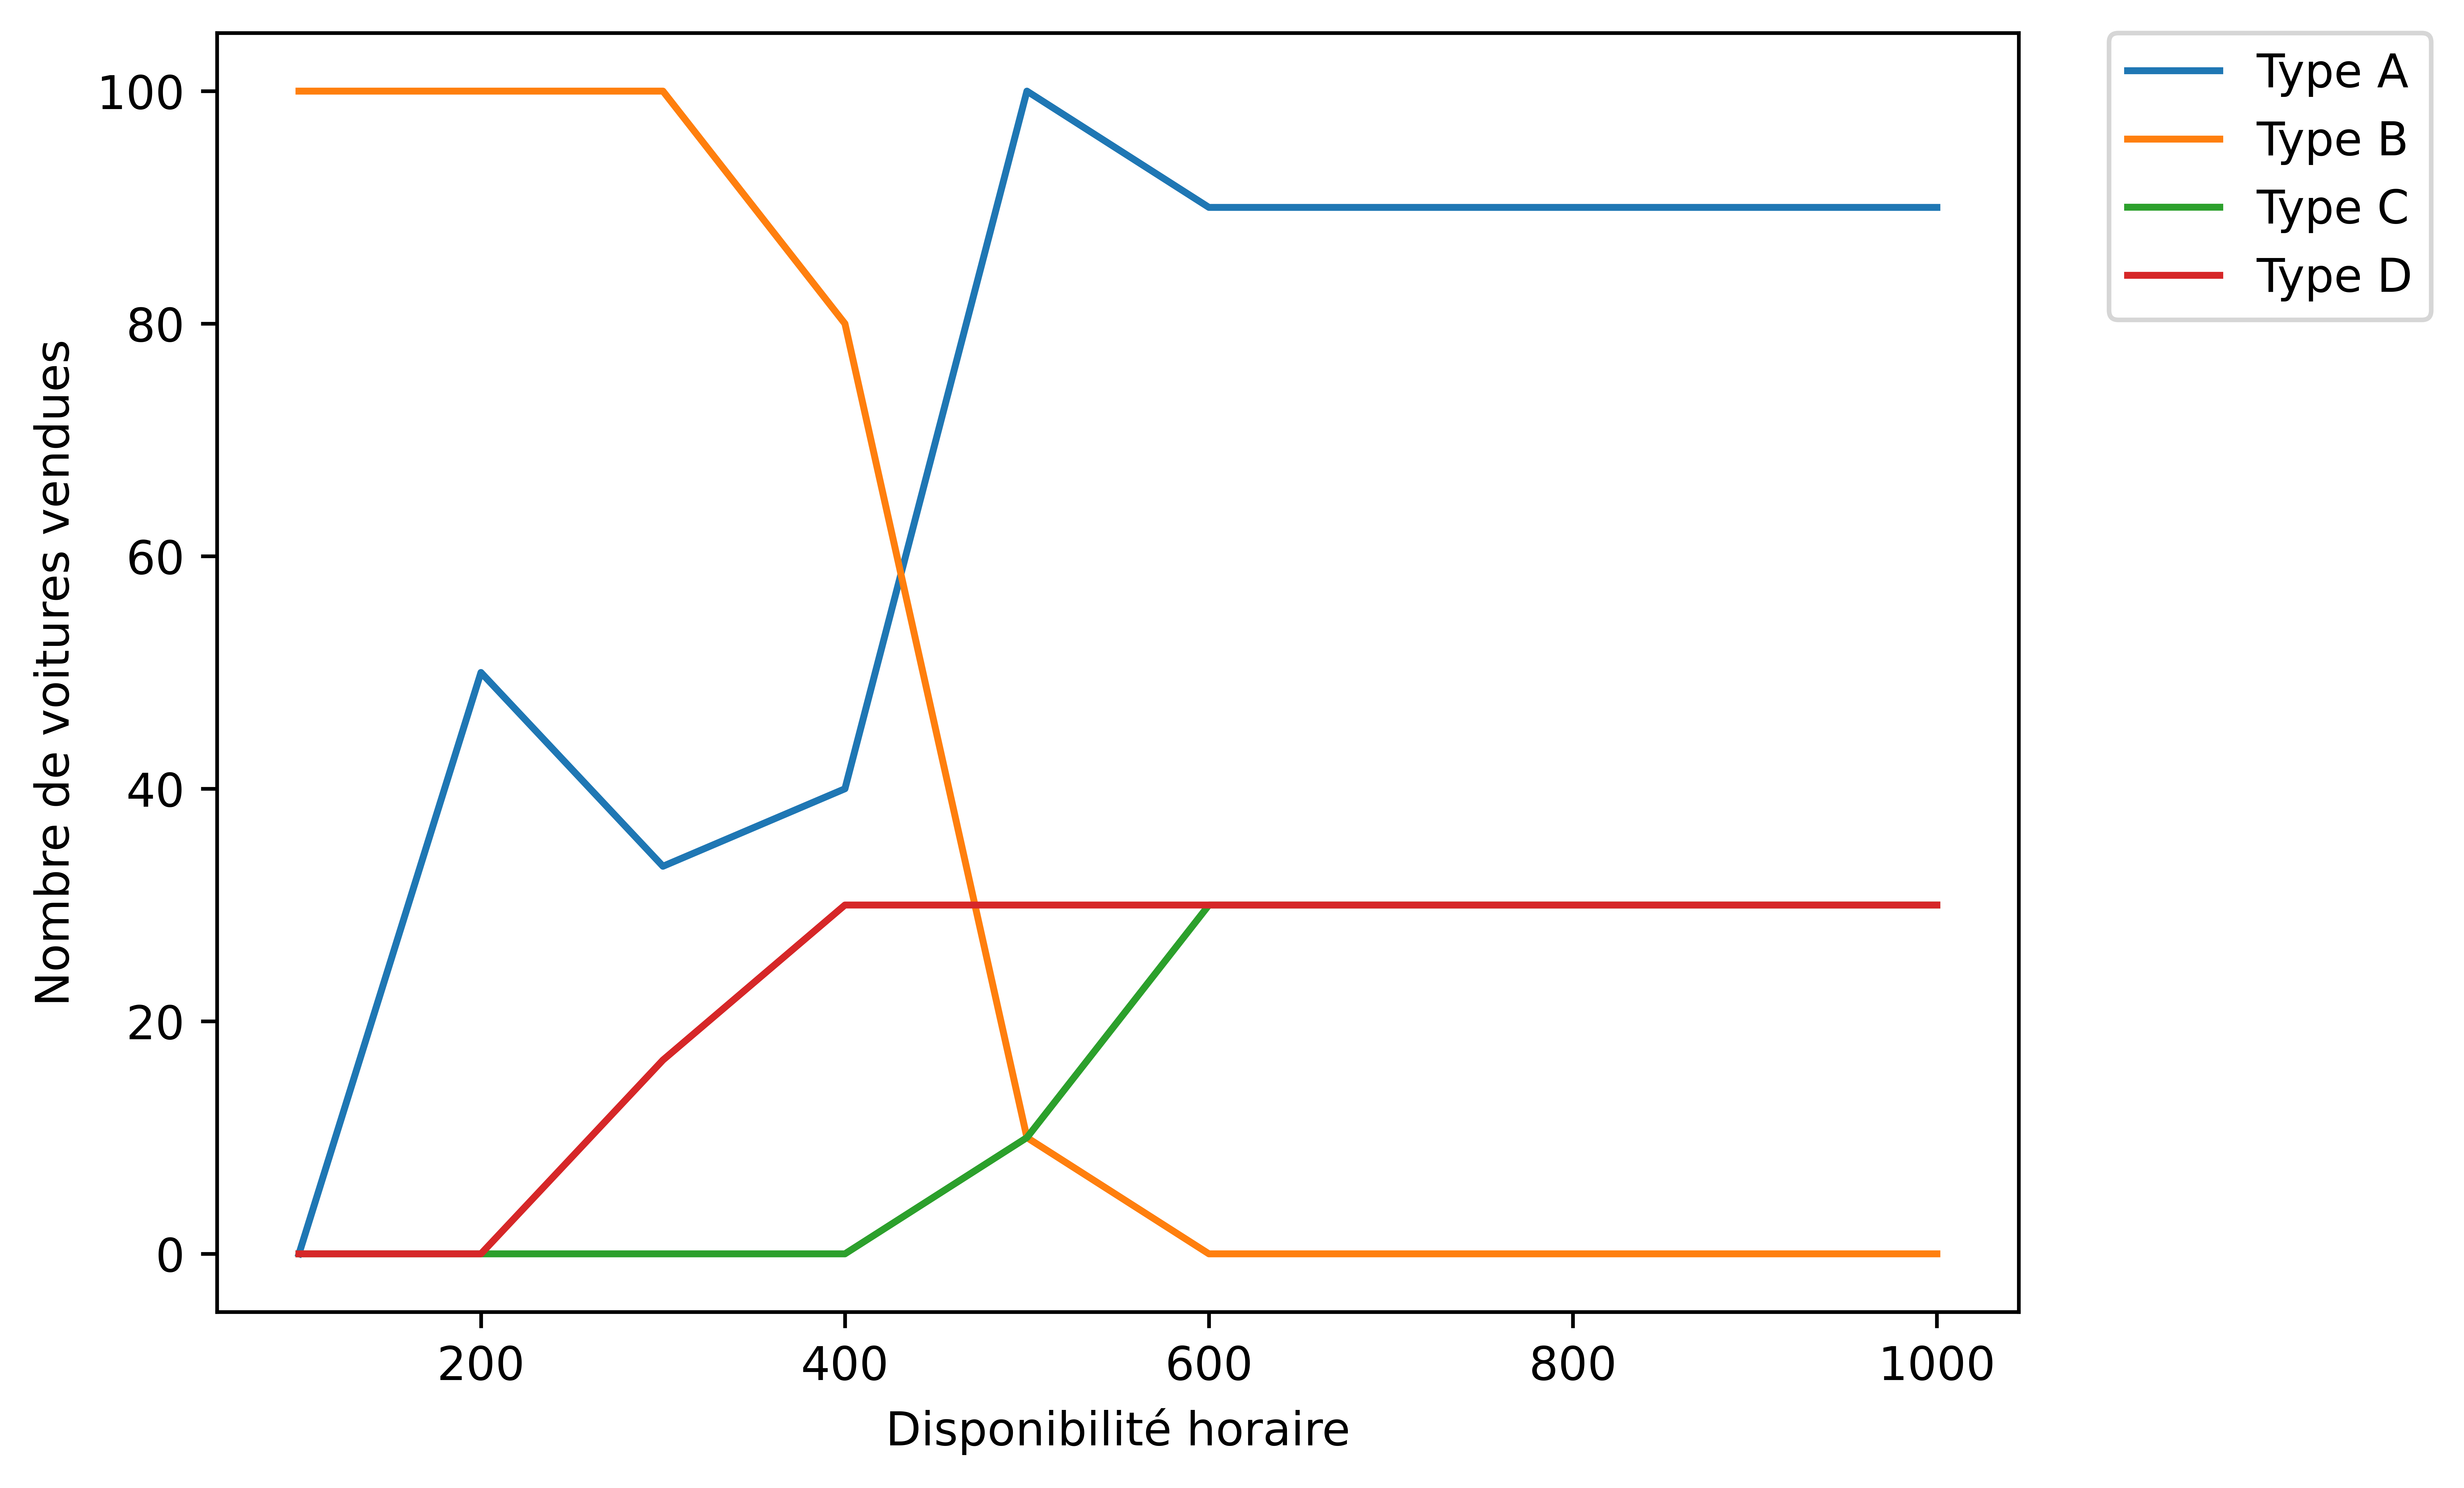

In [24]:
# | fig-align: center
# | fig-width: 50%
# | fig-height: 50%
# | code-fold: true
# | code-summary: "Code du graphique `matplotlib`"
plt.plot(list_time, x1_vente, label="Type A")
plt.plot(list_time, x2_vente, label="Type B")
plt.plot(list_time, x3_vente, label="Type C")
plt.plot(list_time, x4_vente, label="Type D")
plt.xlabel("Disponibilité horaire")
plt.ylabel("Nombre de voitures vendues")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

:::callout-note

Si initialement les voitures de type **B** sont favorisées, on voit que *Car-Nivor* en produit de moins en moins pour focaliser sa production sur les type **A**, et dès qu'elle le peut, elle commence à produire des voitures de Type **D**. Pour finir, elle choisit de compléter sa production avec des voitures de Type **C**.

:::

## Introduction au problème III

> L'usine de production fait remarquer à la direction que les flux de matières premières sont tendus et demande de les prendre en compte pour faire des modèles plus réalistes. Pour ce faire, elle crée le tableau suivant :

In [25]:
# | echo: false
df_materials = pd.DataFrame(
    {
        "Type A": [2.0, 0.2, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0],
        "Type B": [1.0, 0.2, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0],
        "Type C": [4.0, 0.5, 2.0, 1.0, 1.5, 2.0, 1.0, 1.0, 1.0],
        "Type D": [2.0, 1.0, 2.0, 2.0, 0.8, 2.0, 1.2, 1.0, 1.0],
        "Limite des stocks mensuels": [125, 55, 300, 100, 60, 50, 100, 220, 30],
    },
    index=[
        "Fer",
        "Cuivre",
        "Aluminium",
        "Acier",
        "Caoutchouc",
        "Terres rares",
        "Verre",
        "Tissu",
        "Cuir",
    ],
)

In [26]:
# | echo: false
display(df_materials)

Type A  Type B  Type C  Type D  Limite des stocks mensuels
Fer              2.0     1.0     4.0     2.0                         125
Cuivre           0.2     0.2     0.5     1.0                          55
Aluminium        1.0     1.0     2.0     2.0                         300
Acier            2.0     2.0     1.0     2.0                         100
Caoutchouc       1.0     1.0     1.5     0.8                          60
Terres rares     0.0     0.0     2.0     2.0                          50
Verre            1.0     1.0     1.0     1.2                         100
Tissu            2.0     2.0     1.0     1.0                         220
Cuir             0.0     0.0     1.0     1.0                          30

:::callout-caution

## Section en travaux

🐱‍🚀 Patience, ça arrive... {{< iconify svg-spinners:bars-scale-fade >}}

:::